In [353]:
from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Задание 1

## Загрузка датасета

In [354]:
mushroom = fetch_ucirepo(id = 73)  

X = mushroom.data.features 
y = mushroom.data.targets

pd.concat([X, y], axis = 1).head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


## Информация о датасете

In [355]:
# Проверка на отсутствующие значения
print(f'Количество объектов с NaN: {X.isnull().any(axis = 1).sum()}') 

Количество объектов с NaN: 2480


In [356]:
# Удаление объектов с неполными данными
if X.isnull().values.any():
    X = pd.concat([X, y], axis = 1)
    X = X.dropna()

    y = X['poisonous'].to_frame()
    X = X.drop(['poisonous'], axis = 1)

In [357]:
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644,...,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644
unique,6,4,8,2,7,2,2,2,9,2,...,4,7,7,1,2,3,4,6,6,6
top,x,y,g,t,n,f,c,b,p,t,...,s,w,w,p,w,o,p,n,v,d
freq,2840,2220,1696,3184,2776,5626,4620,4940,1384,2880,...,3544,3136,3088,5644,5636,5488,3488,1920,2160,2492


In [358]:
# Так как признак veil-type содержит только одно значение,
# то этот признак не вносит никакого вклада и его можно отбросить
X = X.drop(['veil-type'], axis = 1)

In [359]:
y.value_counts()

poisonous
e            3488
p            2156
Name: count, dtype: int64

## Распределение значений категориальных признаков по классам

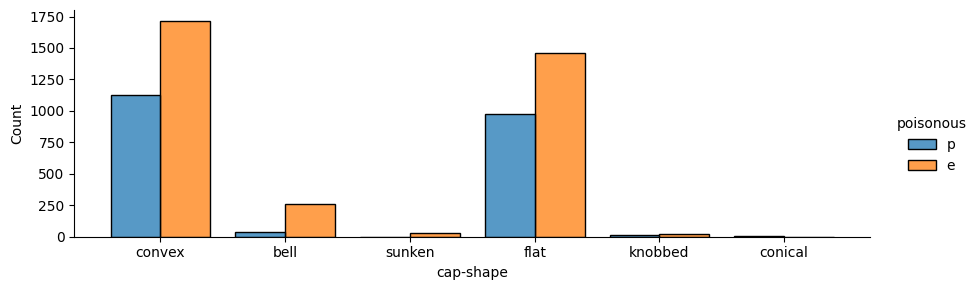

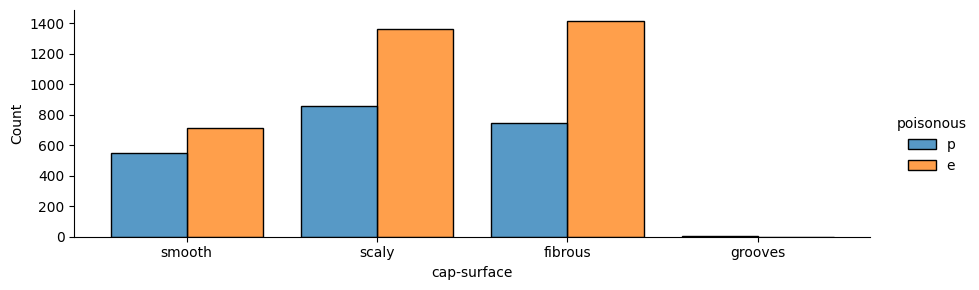

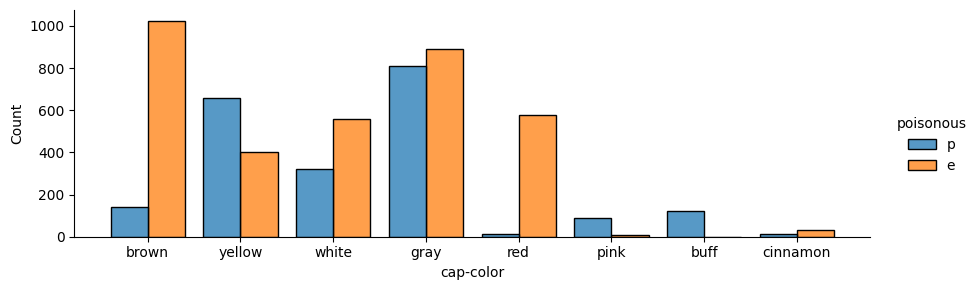

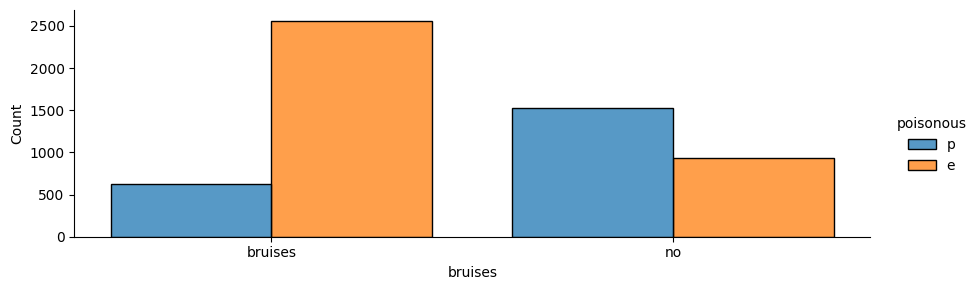

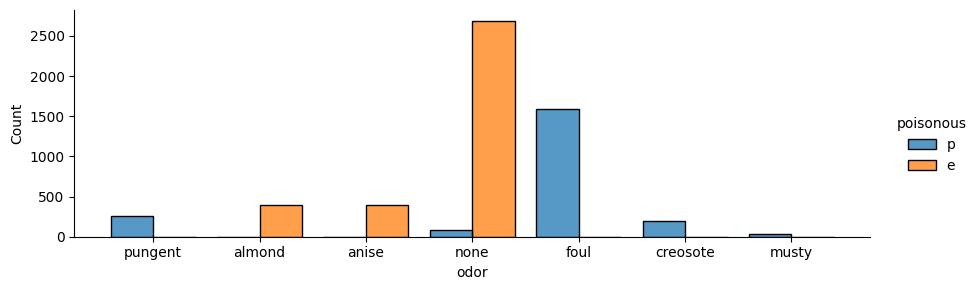

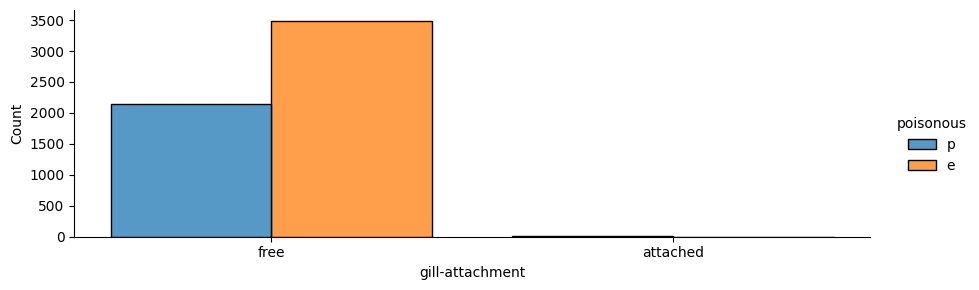

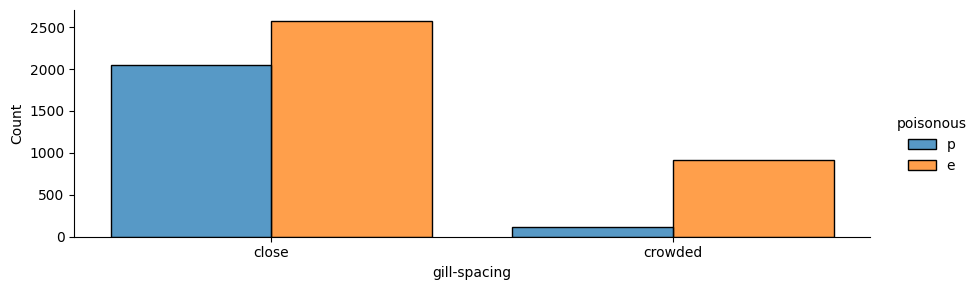

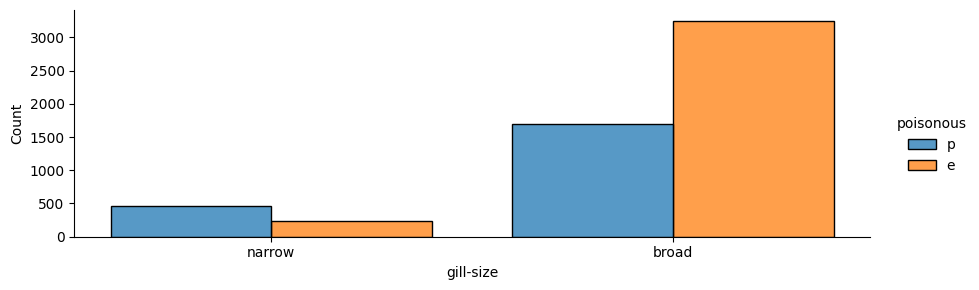

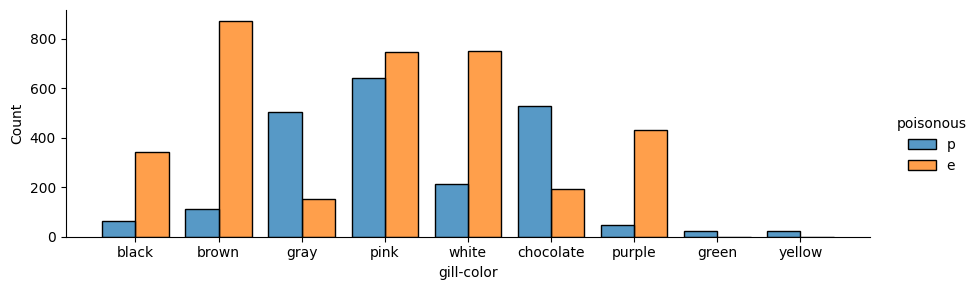

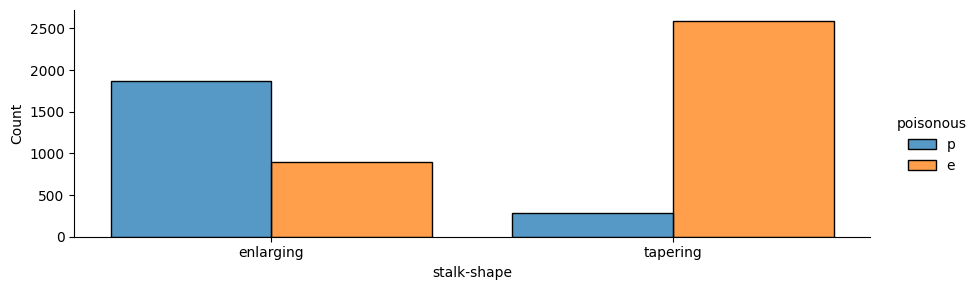

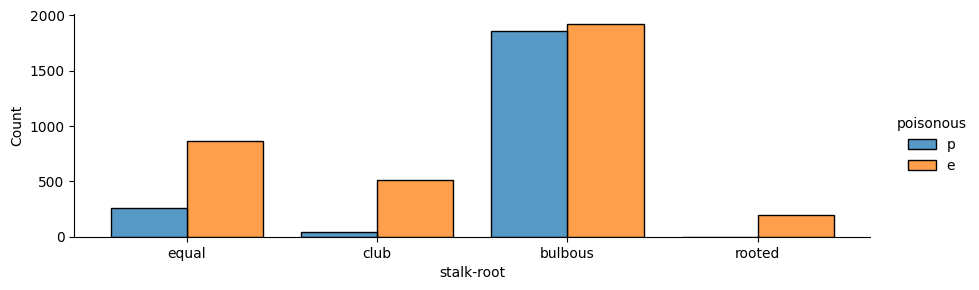

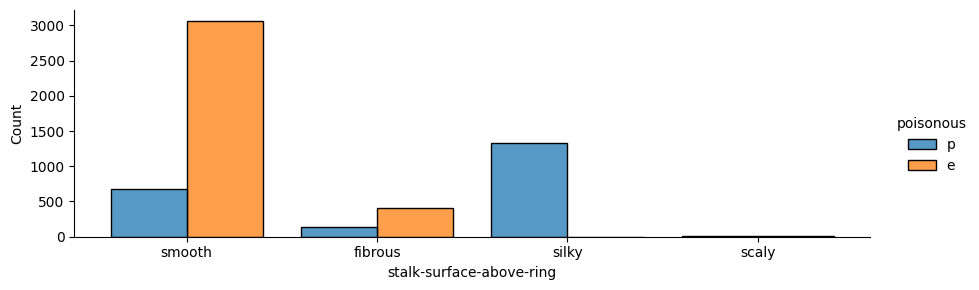

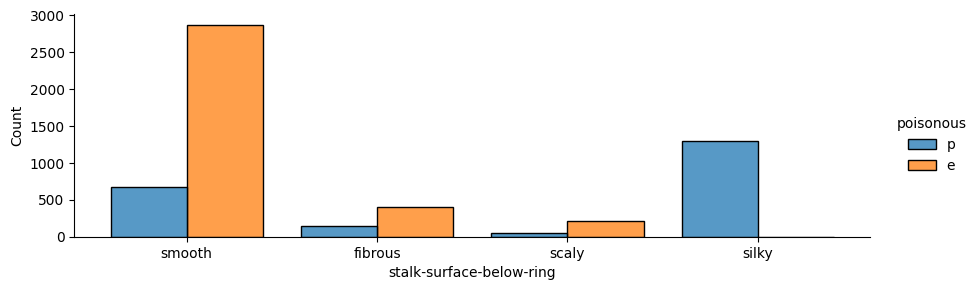

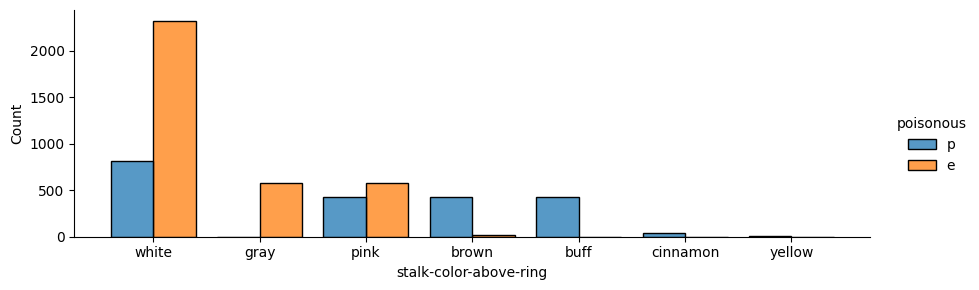

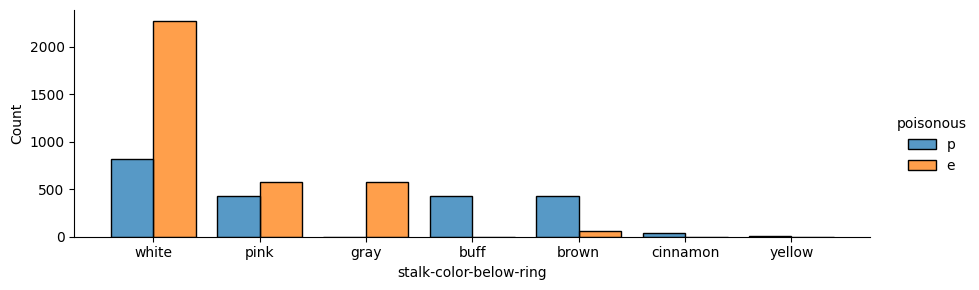

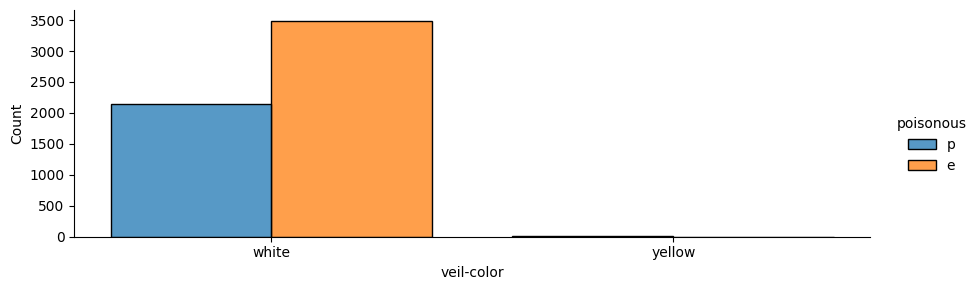

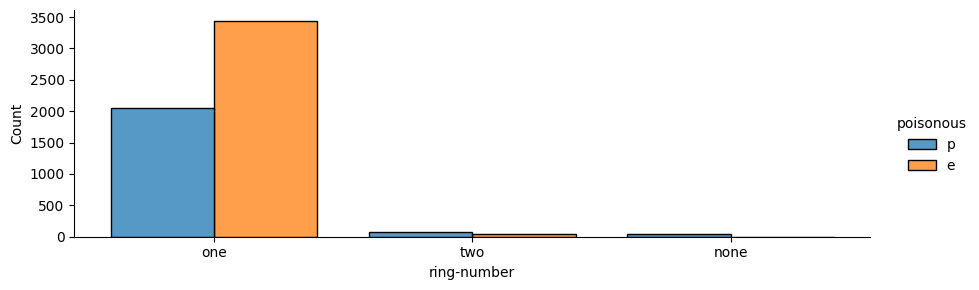

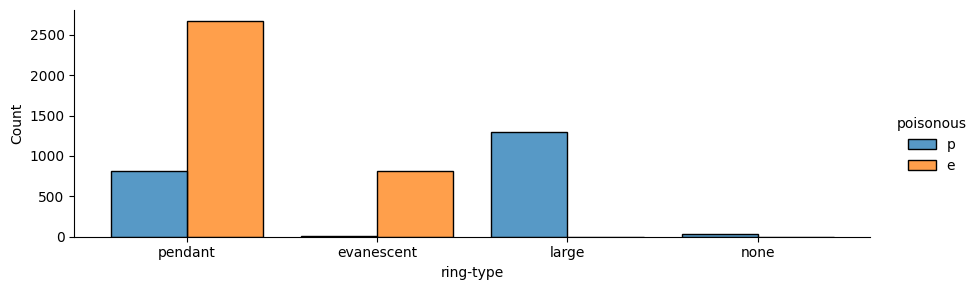

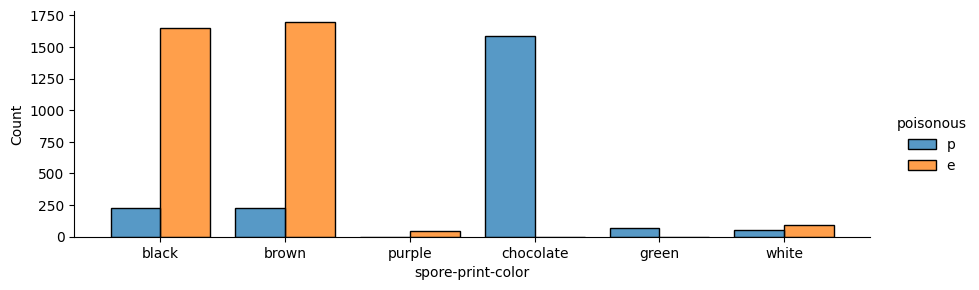

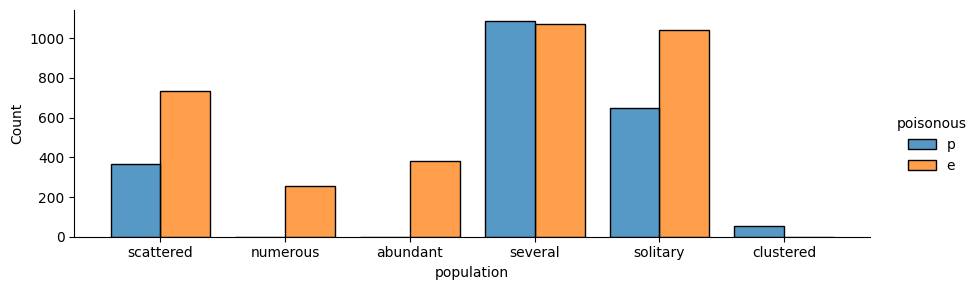

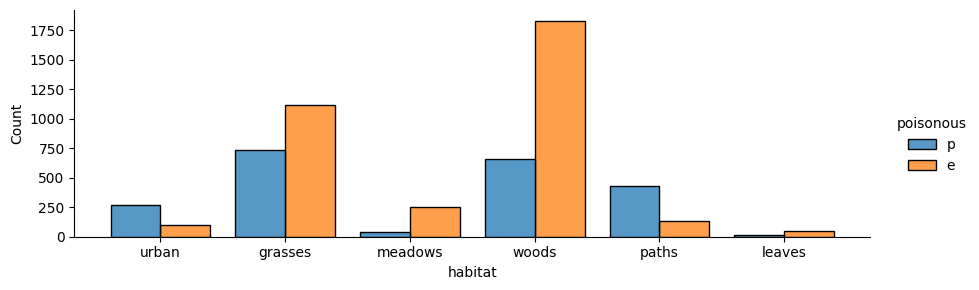

In [360]:
vars = mushroom['variables']

for col_name in X.columns.values:

    # Вывод полных имен признаков
    description = vars.loc[
        vars['name'] == col_name]['description'].values[0].split(',')
        
    for var in description:
        full, abbrev = var.split('=')
        X[col_name] = X[col_name].replace(abbrev.strip(), full.strip())

    sns.displot(X, 
                x = col_name, 
                hue = y['poisonous'], 
                multiple = 'dodge', 
                shrink = .8, 
                height = 3, 
                aspect = 3,
                )

# Задание 2

In [361]:
class Freq_estimator:

    def fit(self, X_train, y_train):

        self.X_train = X_train
        self.X_groups = X_train.groupby(y_train).apply(
            lambda df: df.apply(lambda col: col.value_counts()))
        

        def freq_pair(cls, feature_name, feature_value):

            features = self.X_groups[feature_name][cls].dropna()

            if feature_value not in features:
                return 0
            
            return features[feature_value]
        

        self.X_freqs = {feature_name : 
                       {feature_value : 
                       {class_name: freq_pair(class_name, feature_name, feature_value) 
                        for class_name in y_train.unique()} 
                        for feature_value in X_train[feature_name].unique()}
                        for feature_name in X_train.columns}

        return self

    def predict(self, X_test):

        self.y_pred = pd.DataFrame()

        for feature_name in X_test.columns:
           
           self.y_pred[feature_name] = X_test[feature_name].map(
               lambda feature_value: max(self.X_freqs[feature_name][feature_value], key = self.X_freqs[feature_name][feature_value].get))

        return self.y_pred
    
    def get_metrics(self, y_true):

        return self.y_pred.apply(
            lambda col: accuracy_score(y_true, col)).to_frame('accuracy')

In [362]:
est = Freq_estimator().fit(X, y['poisonous'])
est.X_freqs

{'cap-shape': {'convex': {'p': 1124.0, 'e': 1716.0},
  'bell': {'p': 40.0, 'e': 260.0},
  'sunken': {'p': 0, 'e': 32.0},
  'flat': {'p': 972.0, 'e': 1460.0},
  'knobbed': {'p': 16.0, 'e': 20.0},
  'conical': {'p': 4.0, 'e': 0}},
 'cap-surface': {'smooth': {'p': 548.0, 'e': 712.0},
  'scaly': {'p': 860.0, 'e': 1360.0},
  'fibrous': {'p': 744.0, 'e': 1416.0},
  'grooves': {'p': 4.0, 'e': 0}},
 'cap-color': {'brown': {'p': 140.0, 'e': 1024.0},
  'yellow': {'p': 656.0, 'e': 400.0},
  'white': {'p': 320.0, 'e': 560.0},
  'gray': {'p': 808.0, 'e': 888.0},
  'red': {'p': 12.0, 'e': 576.0},
  'pink': {'p': 88.0, 'e': 8.0},
  'buff': {'p': 120.0, 'e': 0},
  'cinnamon': {'p': 12.0, 'e': 32.0}},
 'bruises': {'bruises': {'p': 624.0, 'e': 2560.0},
  'no': {'p': 1532.0, 'e': 928.0}},
 'odor': {'pungent': {'p': 256.0, 'e': 0},
  'almond': {'p': 0, 'e': 400.0},
  'anise': {'p': 0, 'e': 400.0},
  'none': {'p': 88.0, 'e': 2688.0},
  'foul': {'p': 1584.0, 'e': 0},
  'creosote': {'p': 192.0, 'e': 0},
  'm

In [363]:
est.predict(X)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,e,e,e,p,e,e,p,e,p,...,e,e,e,e,e,e,e,e,e,p
1,e,e,p,e,e,e,e,e,e,p,...,e,e,e,e,e,e,e,e,e,e
2,e,e,e,e,e,e,e,e,e,p,...,e,e,e,e,e,e,e,e,e,e
3,e,e,e,e,p,e,e,p,e,p,...,e,e,e,e,e,e,e,e,e,p
4,e,e,e,p,e,e,e,e,e,e,...,e,e,e,e,e,e,e,e,e,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,e,e,e,p,e,e,e,e,e,p,...,e,e,p,p,e,p,e,e,e,p
8001,e,e,e,p,e,e,e,e,e,p,...,e,e,p,p,e,p,e,e,e,p
8038,e,e,e,e,e,e,e,e,e,p,...,e,e,e,e,e,p,e,e,e,p
8095,e,e,e,p,p,e,e,e,p,p,...,p,e,p,p,e,p,p,e,p,e


In [364]:
metric = est.get_metrics(y)
metric

,accuracy
cap-shape,0.618710
cap-surface,0.618710
cap-color,0.698795
bruises,0.725018
odor,0.984408
gill-attachment,0.621191
gill-spacing,0.618001
gill-size,0.657690
gill-color,0.748051
stalk-shape,0.790220


In [365]:
print(f'Наиболее информативный признак: {metric["accuracy"].idxmax()}')

Наиболее информативный признак: odor


# Задание 3

In [366]:
# Преобразование категориальных признаков в числовые (one-hot)
X = pd.get_dummies(X, dtype = int)

pd.concat([X, y], axis = 1).head()

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,...,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_woods,poisonous
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,p
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,e
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,e
3,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,p
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,e


In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [368]:
naive_bayes = GaussianNB()
fitted_bayes = naive_bayes.fit(X_train, y_train)

In [369]:
y_pred = naive_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.9973427812223207

# Задание 4

In [374]:
class Naive_bayes:

    def fit(self, X_train, y_train):
        
        self.X_train = X_train
        self.y_train = y_train

        self.features = X_train.columns
        self.classes = np.unique(y_train)

        self.prior = [np.sum(y_train == cls) / float(y_train.shape[0]) for cls in self.classes]

        return self

    def predict(self, X_test):

        post_probs = []
        likelihood = 1.0

        for cls in self.classes:

            likelihood *= np.prod(
                [self._conditional_prob(self.X_train[feature_name], self.y_train, X_test[feature_name], cls) for feature_name in self.features])

            posterior = self.prior * likelihood
            post_probs.append(posterior)

        return self.classes[np.argmax(post_probs, axis = 1)]
    
    def _conditional_prob(self, X_train, y_train, feature_val, cls):

        X_filtered = X_train[y_train == cls]

        numerator = np.sum(X_filtered == feature_val)
        denominator = np.sum(y_train == cls)

        return numerator / float(denominator)
    

In [376]:
y_preds = Naive_bayes().fit(X_train, y_train, X_test.iloc[0])
accuracy_score(y_test, y_preds)

TypeError: Singleton array 0 cannot be considered a valid collection.